<a href="https://colab.research.google.com/github/etatc/NCBIminer/blob/main/pokemoncnnautoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

!pip install -q kaggle

In [ ]:
uploaded = files.upload()

In [2]:
!mkdir /.kaggle

In [6]:
!cp /content/kaggle.json ~/.kaggle/kaggle.json

In [7]:
!chmod 600 /root/.kaggle/kaggle.json

In [8]:
!kaggle datasets download -d hannesrosenbusch/6036-labeled-pokemon-pictures

 96% 80.0M/83.1M [00:01<00:00, 71.4MB/s]
100% 83.1M/83.1M [00:01<00:00, 74.7MB/s]


In [9]:
from zipfile import ZipFile

# Create a ZipFile Object and load sample.zip in it
with ZipFile('6036-labeled-pokemon-pictures.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

In [10]:
import numpy as np
x_train = np.load('poke_image_data.npy','r')
x_test = np.load('poke_image_data.npy','r')

In [11]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_test = x_test[3000:]
x_train = x_train[:3000]
print(x_train.shape)
print(x_test.shape)

(3000, 100, 100, 3)
(3036, 100, 100, 3)


In [12]:
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Reshape, Input
from keras.models import Sequential, Model
import keras.models as model
from keras import backend as K

In [13]:
def build_encoder(img_shape):
    # The encoder
    encoder = Sequential()
    encoder.add(Conv2D(50, (3, 3), activation='relu', input_shape=(img_shape)))
    encoder.add(MaxPooling2D((2, 2)))
    encoder.add(Conv2D(25, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPooling2D((2, 2),  padding='same'))
    encoded = encoder.layers[3].output
    
    '''= K.function([encoder.layers[0].input],
                                  [encoder.layers[3].output])
    encoded = o([x])[0]
    '''
    return encoder, encoded

def build_decoder(img_shape):
    # The decoder
    decoder = Sequential()
    decoder.add(Conv2DTranspose(25, (3, 3), strides=2, activation='relu', padding='same', input_shape=(img_shape)))
    decoder.add(Conv2DTranspose(50, (3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))
    #decoder.add(Reshape((100, 100, 3)))
    decoded = decoder.layers[2].output

    return decoder, decoded

In [31]:
img_shape = x_train.shape[1:]
encoder, encoded = build_encoder(img_shape)

decoder, decoded = build_decoder(encoded.shape[1:])

inp = Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

print(autoencoder.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 25, 25, 25)        12675     
_________________________________________________________________
sequential_3 (Sequential)    (None, 100, 100, 3)       18303     
Total params: 30,978
Trainable params: 30,978
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
import matplotlib.pyplot as plt

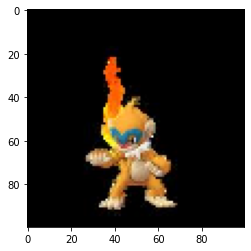

In [16]:
plt.imshow(x_test[460].reshape(100,100,3))

In [18]:
autoencoder.load_weights('autoencoder6.h5')

In [29]:
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(x_train, x_train))

Epoch 1/100
60/60 [==============================] - 38s 77ms/step - loss: 0.0194 - val_loss: 0.0063
Epoch 2/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 3/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 4/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 5/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 6/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 7/100
60/60 [==============================] - 4s 72ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 8/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0059 - val_loss: 0.0060
Epoch 9/100
60/60 [==============================] - 4s 72ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 10/100
60/60 [==============================] - 4s 71ms/step - loss: 0.0060 - val_loss: 0.006

In [30]:
autoencoder.save('autoencoder6.h5')

In [19]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

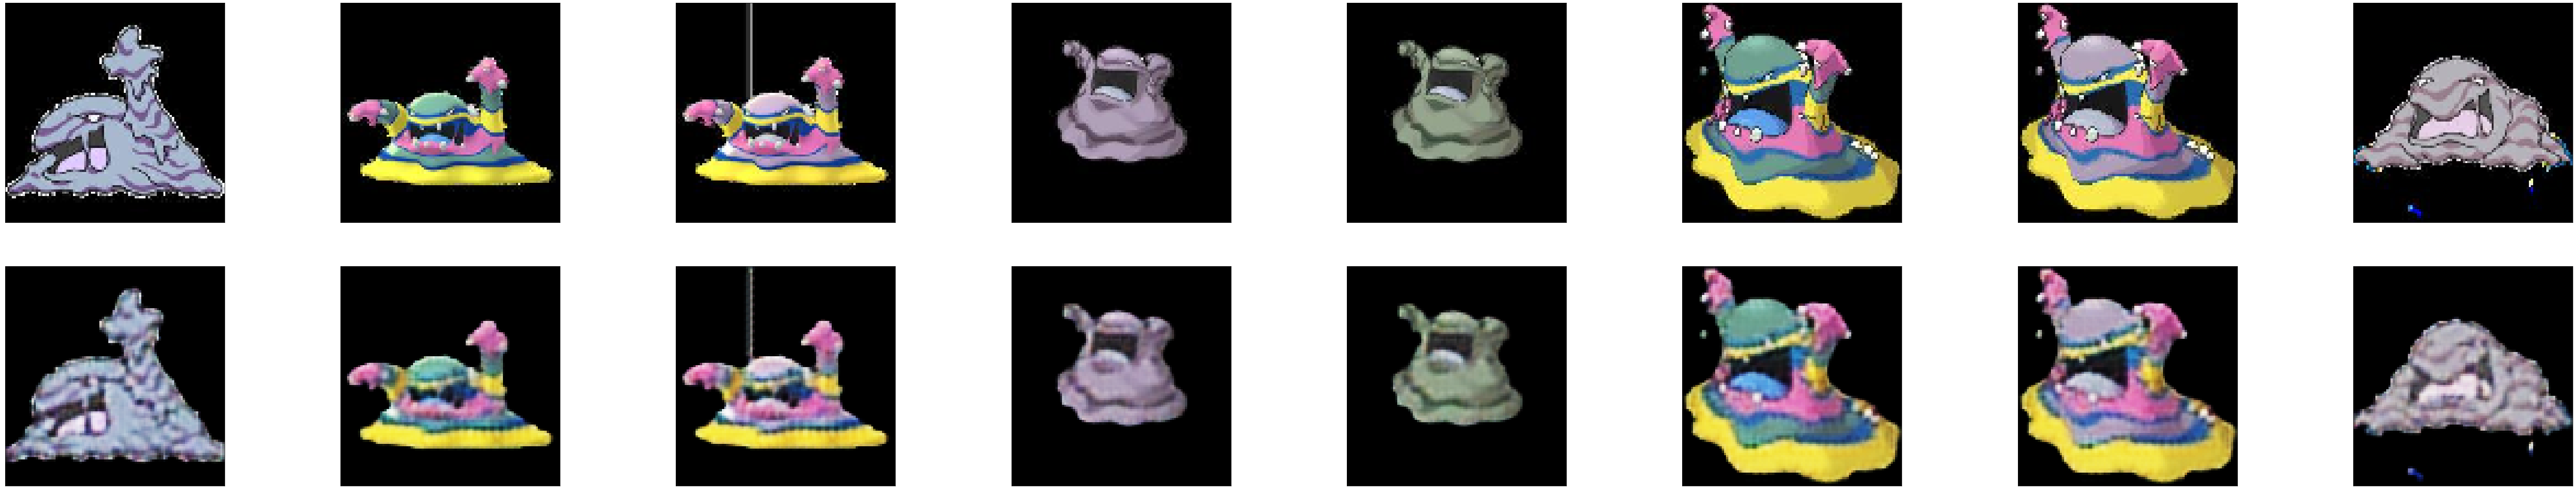

In [30]:
import matplotlib.pyplot as plt

n = 8 # how many digits we will display
j = 500 # shift the viewing window
plt.figure(figsize=(100, 60))
for i in range(n):
    # display original
    ax = plt.subplot(6, n, i + 1)
    plt.imshow(x_test[i + j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(6, n, i + 1 + n)
    plt.imshow(decoded_imgs[i + j])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()